# **POD-NN**

POD-NN (usefull when you do not have affinity, so you cannot exploite offline-online phase) is a strategy that allows not to rely on affinity on the online stage: the projection stage is not performed and thus the speedup is guaranteed, yet having accurate solutions.

The POD-NN algorithm relies on two stages:
1. a POD,
2. a training of a Feed-forward Neural Network that predicts the entries of the reduced vector $u_{\mathsf{rb}}$.

As usual, we need **a lot of FOM simulations**. Let us import gedim!

In [1]:
import sys
sys.path.append('../../CppToPython')

In [2]:
import numpy as np
import GeDiM4Py as gedim

In [3]:
lib = gedim.ImportLibrary("../../CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 }
gedim.Initialize(config, lib)

## The parametric version of the heat conductivity equation

Solving the following equation on square $\bar{\Omega} = [-1, +1] \times [-1, +1]$, studying a parametric diffiusion coefficient 

$$
\begin{cases}
\nabla \cdot (k_{\mu} \nabla u) = 0 & \text{in } \Omega\\
k_{\mu} \nabla u \cdot n_1 = \mu_2 & \text{in } \Gamma_{down}\\
u = \sin(\mu_3\pi x) & \text{in } \Gamma_{up} \text{ - here we can see that we cannot use the affinity: no separation of variable}\\
k_{\mu} \nabla u \cdot n_2 = 0 & \text{otherwise  Omogeneuson Neumann} 
\end{cases}
$$

where $k = \mu_1$ if $x^2 + y^2 \leq R^2$ and $k = 1$ otherwise. 
The parametric space is $\mathcal P = [0.1, 10] \times [0,1] \times [-1, 1]$.

The problem is _standard_. However, we note a nonlinear dependency of the Dirichlet boundary term over $\Gamma_{up}$ --> here is the problem, the $\sin$!

In [4]:
def Heat_R():
	return 0.5 # Take the radius

def Domain(numPoints, points): # Put 1 allover the points to consider all the domain
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.ones(numPoints)
	return values.ctypes.data

############## DIRICHLET VARYING WRT mu_3 #####################
def Dirichlet_Term(numPoints, points): # We do not put here another depencency (mu_3) because Gedim does not support this 
    # So we will define mu_3 and after call this function
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.ones(numPoints)
	for p in range(0, numPoints):
        # The values on the Dirichlet boundary I set the value sin(mu_3 * pi * x) 
		values[p] = np.sin(mu_3*np.pi*matPoints[0,p])  ### mu_3 is not defined, but not a problem
	return values.ctypes.data
###################

def Circle(numPoints, points): # In the circle
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.ones(numPoints)
	for p in range(0, numPoints):
		if (matPoints[0,p] * matPoints[0,p] + matPoints[1,p] * matPoints[1,p]) > (Heat_R() * Heat_R() + 1.0e-16):
			values[p] = 0. 
	return values.ctypes.data

def NotCircle(numPoints, points): # Out of the circle
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.ones(numPoints)
	for p in range(0, numPoints):
		if (matPoints[0,p] * matPoints[0,p] + matPoints[1,p] * matPoints[1,p]) <= (Heat_R() * Heat_R() + 1.0e-16):
			values[p] = 0. 
	return values.ctypes.data

def Heat_weakTerm_down(numPoints, points): 
	values = np.ones(numPoints) 
	return values.ctypes.data

Let us define the High Fidelity Simulation Parameters and import the mesh.

In [5]:
order = 1

In [6]:
%%writefile ImportMesh.csv
InputFolderPath
../../CppToPython/Meshes/Mesh3

Overwriting ImportMesh.csv


In [7]:
[meshInfo, mesh] = gedim.ImportDomainMesh2D(lib)

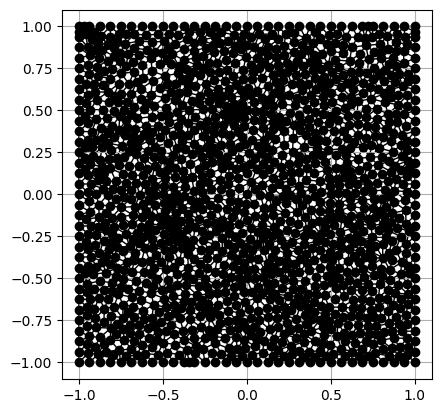

In [8]:
gedim.PlotMesh(mesh)

Let us create the space

In [9]:
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 3, 3, 2] }
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

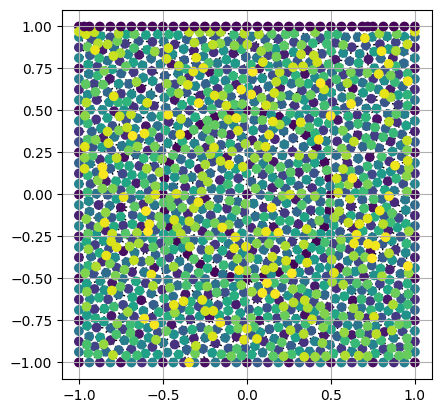

In [10]:
gedim.PlotDofs(mesh, dofs, strongs)

### **Assemble the system**
We can assemble only the parts that are $\mu-$ independent (together with the inner product matrix!). Namely, the Dirichlet term needs to be assembled later on. It is non-affine and nonlinear w.r.t to the parameter $\boldsymbol\mu$!


In [11]:
[stiffness1, stiffnessStrong1] = gedim.AssembleStiffnessMatrix(NotCircle, problemData, lib)

# Moltiply to the inner prodocond (as lab 2), to deal with non omogenoeus condition
[stiffness2, stiffnessStrong2] = gedim.AssembleStiffnessMatrix(Circle, problemData, lib) 

weakTerm_down1 = gedim.AssembleWeakTerm(Heat_weakTerm_down, 1, problemData, lib)

#### inner product  
# ||grad(u)||^2 
inner_product = stiffness1 + stiffness2 # Inner product matrix (same notation of the theory stiffness_matrix = A)

######## DIRICHLET CANNOT BE ASSEMBLED NOW #########################
# We want to performe simulation for different parameters --> so every time that we performe this operation,
# before to doing that, we have to define the Dirichlet condition, compute everything, and definte it again

Let us define the training set for the POD

In [12]:
### define the training set

snapshot_num = 300
mu1_range = [0.1, 10.]
mu2_range = [-1., 1.]
mu3_range = [-1., 1.]
P = np.array([mu1_range, mu2_range, mu3_range])

training_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(snapshot_num, P.shape[0]))

We can now proceed with the snapshot matrix creation. However, we need to be careful: the problem is not affine in the parameters and we need to assemble the Dirichlet term for each parametric instance.

In [13]:
#### snapshot matrix creation
thetaA1 = 1
snapshot_matrix = []

tol = 1. - 1e-7
N_max = 10

for mu in training_set: # All the parameters that I have to use
  thetaA2 = mu[0]
  thetaf1 = mu[1]
  mu_3 = mu[2]
  
  #### the problem is not affine: I have to assemble in this stage!! ###
  ## label --> in that way assemble the Dirichlet term non-omogeneous
  Dirichlet_top = gedim.AssembleStrongSolution(Dirichlet_Term, 3, problemData, lib) 
  f1_D = stiffnessStrong1 @ Dirichlet_top # Change the value of the forcing term considering the Dirichlet condition
  f2_D = stiffnessStrong2 @ Dirichlet_top

  stiffness = thetaA1*stiffness1 + thetaA2*stiffness2
  weakTerm_down = thetaf1*weakTerm_down1 # Forcing to the Neumann boundary condition
  Dirichlet_contribution = thetaA1*f1_D + thetaA2*f2_D # Contribution on the Dirichlet boundary condition
  
  f = weakTerm_down - Dirichlet_contribution
  
  snapshot = gedim.LUSolver(stiffness, f, lib)
  
  # if you do not want to plot uncomment
  # gedim.PlotSolution(mesh, dofs, strongs, snapshot, Dirichlet_top)
  snapshot_matrix.append(np.copy(snapshot))

snapshot_matrix = np.array(snapshot_matrix) 

Let us build and analyze the covariance matrix.

In [14]:
### covariance matrix

C = snapshot_matrix @ inner_product @ np.transpose(snapshot_matrix) # Build covariance wrt the inner product

# VM, L, VMt = np.linalg.svd((C))

# Look for eigenvalue (as to be real and non-negative) and eigenvector 
L_e, VM_e = np.linalg.eig(C)
eigenvalues = []
eigenvectors = []


#### check
for i in range(len(L_e)):
  eig_real = L_e[i].real
  eig_complex = L_e[i].imag
  assert np.isclose(eig_complex, 0.) # Check if the eigenvalue are non-negative 
  eigenvalues.append(eig_real)
  eigenvectors.append(VM_e[i].real)


total_energy = sum(eigenvalues)
retained_energy_vector = np.cumsum(eigenvalues)
relative_retained_energy = retained_energy_vector/total_energy # To check the torelance (as always)


if all(flag==False for flag in relative_retained_energy>= tol):
  N = N_max
else:
  N = np.argmax(relative_retained_energy >= tol) + 1

print(N)
print(relative_retained_energy) # In 9 basis function we reach a good approximation 
# --> here that we have non-linearity, the number of basis function that we have to use
# is increased (in the other lab was only 3)

9
[0.92034006 0.97085465 0.99625438 0.99909937 0.99997566 0.99999823
 0.99999961 0.99999985 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1

And now let us build the basis functions and $\mathbb B$.

In [15]:
# Create the basis function matrix
basis_functions = []
for n in range(N):
  eigenvector =  eigenvectors[n]
  basis = np.transpose(snapshot_matrix)@eigenvector
  norm = np.sqrt(np.transpose(basis) @ inner_product @ basis) ## inner product
  basis /= norm # To have more stability on the bases --> Good operation that we have to do!
  basis_functions.append(np.copy(basis))

basis_functions = np.transpose(np.array(basis_functions))

# FINISH THE OFFLINE PHASE, now consider another parameter and compute the online phase

If we want to perform standard ROMs we still need to assemble the system.

**During offline phase** you have to perform
- POD
- Project: $Au=f$, where $f$ is the inner condition and compute
  $$ \sum_{q_A} \Theta_A^{q_A} (\mu) A^{q_A} = \sum_{q_f} \Theta_f^{q_f} (\mu) f^{q_f}$$
- Store $A_N^{q_A}$ & $f_N^{q_f}$ so that during the online phase you have only to compute the $\mu :=$ the weight

**Can we asseble it?**

In [16]:
########## ASSEMBLE WHAT I CAN ##### STILL OFFLINE 
# I can assemble the reduced stiffness matrix
# Online I'll assemble the Dirichlet term
reduced_stiff1 = np.transpose(basis_functions) @ stiffness1 @ basis_functions
reduced_stiff2 = np.transpose(basis_functions) @ stiffness2 @ basis_functions
reduced_w =  np.transpose(basis_functions) @ weakTerm_down1


For each new parameter I have to assemble the Dirichlet term, once again.

In [17]:
########### I CANNOT DO THAT ################ STILL ONLINE??? WE NEED THE PARAMETER
thetaA2 = 2.
thetaf1 = 0.8
mu_3 = 1.
  

In [18]:
#### the problem is not affine: I have to assemble in this stage!! ###

Dirichlet_top = gedim.AssembleStrongSolution(Dirichlet_Term, 3, problemData, lib) ## label 
f1_D = stiffnessStrong1 @ Dirichlet_top
f2_D = stiffnessStrong2 @ Dirichlet_top
r_f1_D = np.transpose(basis_functions) @ (stiffnessStrong1 @ Dirichlet_top)
r_f2_D = np.transpose(basis_functions) @ (stiffnessStrong2 @ Dirichlet_top)


**Solve linear system for a new $\mu$**


In [19]:
reduced_rhs = thetaA1*reduced_stiff1 + thetaA2*reduced_stiff2
reduced_lhs = thetaf1*reduced_w - (thetaA1*r_f1_D + thetaA2*r_f2_D)

In [20]:
#####solve 
reduced_solution = np.linalg.solve(reduced_rhs, reduced_lhs)
print(reduced_solution)

[ -6.03581072   0.71357335  -2.71814498  23.38612387 -22.62647494
   0.54477816  -0.73222505  15.39373308   1.74032697]


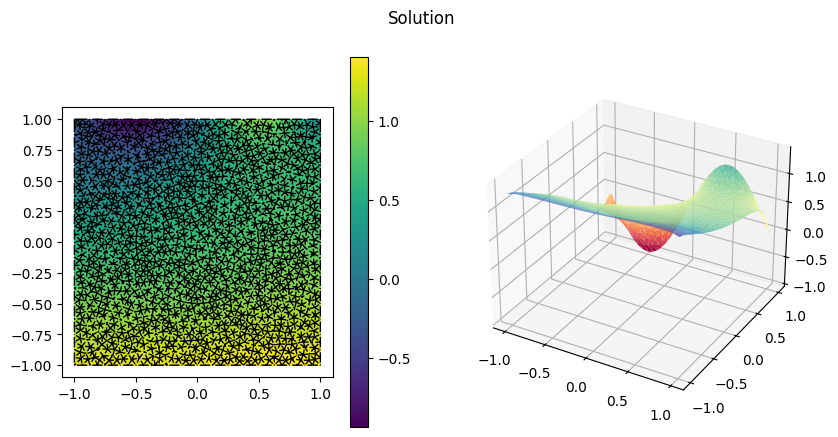

In [21]:
###### plot #######
proj_reduced_solution = basis_functions @ reduced_solution
gedim.PlotSolution(mesh, dofs, strongs, proj_reduced_solution, Dirichlet_top)

stiffness = thetaA1*stiffness1 + thetaA2*stiffness2
weakTerm_down = thetaf1*weakTerm_down1
f = weakTerm_down - (thetaA1*stiffnessStrong1 + thetaA2*stiffnessStrong2) @ Dirichlet_top
  
full_solution = gedim.LUSolver(stiffness, f, lib)

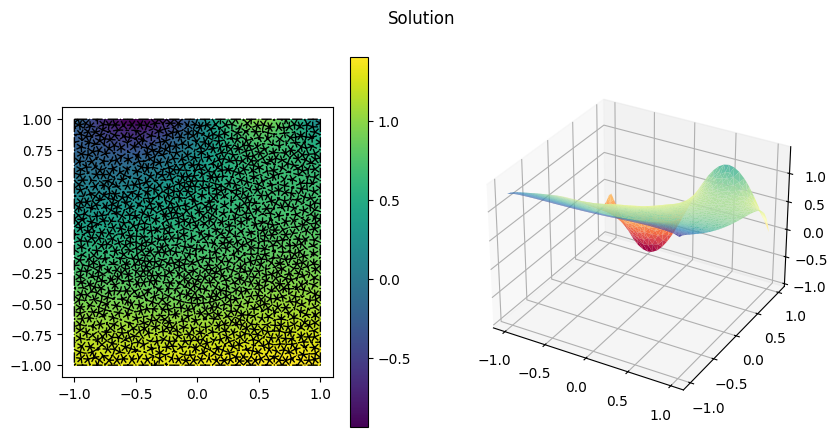

In [22]:
gedim.PlotSolution(mesh, dofs, strongs, full_solution, Dirichlet_top)

Let us comment a bit on the error analysis and the _speed up_.

In [23]:
### compute error
import time

abs_err = []
rel_err = []
testing_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(100, P.shape[0]))
speed_up = []

print("Computing error and speedup analysis") # Same block that we already see to compute the error

for mu in testing_set:
  thetaA2 = mu[0]
  thetaf1 = mu[1]
  mu_3 = mu[2]
  
  #### the problem is not affine: I have to assemble in this stage!! ###
  start_assembling = time.time()
  Dirichlet_top = gedim.AssembleStrongSolution(Dirichlet_Term, 3, problemData, lib) ## label 
  f1_D = stiffnessStrong1 @ Dirichlet_top
  f2_D = stiffnessStrong2 @ Dirichlet_top
  r_f1_D = np.transpose(basis_functions) @ (stiffnessStrong1 @ Dirichlet_top)
  r_f2_D = np.transpose(basis_functions) @ (stiffnessStrong2 @ Dirichlet_top)
  time_assembling =  time.time() - start_assembling # Time of assemble the part of the problem -> everytime you have to assemble the problem

  ##### full #####
  stiffness = thetaA1*stiffness1 + thetaA2*stiffness2
  weakTerm_down = thetaf1*weakTerm_down1
  f = weakTerm_down - (thetaA1*stiffnessStrong1 + thetaA2*stiffnessStrong2) @ Dirichlet_top
  
  
  start_fom = time.time()
  full_solution = gedim.LUSolver(stiffness, f, lib)
  time_fom = time.time() - start_fom # Here not adding the time for assembling 

  #### reduced #####
  reduced_rhs = thetaA1*reduced_stiff1 + thetaA2*reduced_stiff2
  reduced_lhs = thetaf1*reduced_w - (thetaA1*r_f1_D + thetaA2*r_f2_D)
  
  start_rom = time.time()
  reduced_solution = np.linalg.solve(reduced_rhs, reduced_lhs)
  time_rom = time.time() - start_rom
  
  speed_up.append(time_fom/(time_rom + time_assembling)) # Time assembling is for ROM and FOM so, NOT like here,
                                                        # you have to take in account in all the two part

  proj_reduced_solution = basis_functions@reduced_solution

  ### computing error
  error_function = full_solution - proj_reduced_solution
  error_norm_squared_component = np.transpose(error_function) @ inner_product @ error_function
  absolute_error = np.sqrt(abs(error_norm_squared_component))
  abs_err.append(absolute_error)
  
  full_solution_norm_squared_component = np.transpose(full_solution) @  inner_product @ full_solution
  relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
  rel_err.append(relative_error)

Computing error and speedup analysis


In [24]:
print("avarege relative error = ", np.mean(rel_err) )
print("avarege absolute error = ", np.mean(abs_err) )
print("avarege speed_up = ", np.mean(speed_up) )

avarege relative error =  0.00045595117863909046
avarege absolute error =  0.0016646749673025001
avarege speed_up =  12.673577305539716


The speed up is quite small for a linear problem. Let understand the role of POD-NN in this setting. 

We want to use a feed-forward NN. Let us define the Class Net with pytorch.

**POD NN**
- Apply POD
- Train $\Pi^{NN}(\mu$, $\mu \rightarrow u(\mu)$ where $\mu \in \mathcal{R}^3$ and $u(\mu) \in \mathcal{R}^N$, that in this case $N=9$, chosen by the POD (tol that we select before)

The dimension $N$ is fixed before with the value of the tollerance.

**NB** More parameters, more basis function, the number of the basis function is related to the dinamics complete of the parameters, where they are, which dimension have

In [25]:
# Define the Net
import torch
import torch.nn as nn
import torch.nn.functional as F

mu_dim = P.shape[0]
basis_dim = N 

# I need this dimension
input_dim = mu_dim
output_dim = basis_dim

nodes = 30

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Starting layer
        self.fc1 = nn.Linear(input_dim, nodes) 
        
        # Hidden layer
        self.fc2 = nn.Linear(nodes, nodes)
        self.fc3 = nn.Linear(nodes, nodes)
        self.fc4 = nn.Linear(nodes, nodes)
        # Finish hidden layer

        # Last layer
        self.fc5 = nn.Linear(nodes, output_dim)
        
        self.tanh = nn.Tanh()
        # self.apply(self._init_weights)


    def forward(self, x):  ### Forward law ----> prediction
        # Activation function
        x = self.tanh(self.fc1(x)) # Iperbolic tangent [-1, 1]
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.tanh(self.fc4(x))
        
        x = self.fc5(x) # This is the output, we do not change the range of the solution
        # It is better to leave the final solution in the space where it is to do not modify it
        
        return x

In [26]:
seed_num = 31 # You can change this, different seed == different initialization of weight --> maybe better performance

torch.manual_seed(seed_num)
net = Net()
torch.set_default_dtype(torch.float32)

my_loss = nn.MSELoss() # MSE loss
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

epoch_max = 500000
epoch = 0
tol = 1e-5
loss = 1. # To start the optimization

We need to prepare the outputs to train the NN. Indeed, our goal is to define 
$$
\boldsymbol \pi(\boldsymbol \mu) = \underline{u}_{\mathsf{rb}}^{NN}(\boldsymbol \mu).
$$
 Namely, our inputs are the parameters of the training set and the output is the Galerkin projection of the snapshots of the training set.
 The output is of the form $\underline{u}_{\mathsf{rb}}$ where:
 $$
 \mathbb B \underline{u}_{\mathsf{rb}}(\boldsymbol \mu) = \mathbb P^{\boldsymbol \mu}u_{{\delta}}(\boldsymbol \mu), \quad \quad (1)
 $$
 where $\mathbb P^{\boldsymbol \mu} = \mathbb B \mathbb X_{N}^{-1} \mathbb B^T\mathbb X_{N_{\delta}}$ (direct projection, projecjtion matrix along the line in which I project, this is not a change of variable) is the reduced vector related to the Galrkin projector, i.e. the best approximation of $u_\delta$ in $V_N$ w.r.t. the inner-product defined by the matrix $X_\delta$.

 Instead of computing the inverse of $\mathbb X_{N} = \mathbb B^T \mathbb X_{{\delta}} \mathbb B$ we solve the following system:
 $$
 \mathbb B^T \mathbb X_{{\delta}} \mathbb B \underline{u}_{\mathsf {rb}}(\boldsymbol \mu) =
  \mathbb B^T \mathbb X_{{\delta}} u_{{\delta}}(\boldsymbol \mu)
 $$
 to find $u_{\mathsf{rb}}(\boldsymbol \mu)$ for each snapshot.

In this way we are taking the vector of the reduced solution related to the parameter $\boldsymbol \mu$ **without solving the reduced system**, thanks to the relation (1). This element is the closest element (the best choice) to $u_{\delta}$ in the norm of the problem.


**Computation** performe during the theory (check lesson 10 or 11)
$$ \mathbb B^T \mathbb X_{{\delta}} \mathbb B \underline{u}_{\mathsf {rb}} = \mathbb B^T \mathbb X_{{\delta}} u_{{\delta}}(\boldsymbol \mu)$$
$$ \underline{u}_{\mathsf {rb}} =  \mathbb X_{N}^{-1} \mathbb B^T \mathbb X_{{\delta}} u_{\delta}$$
Inverte the matrix is NOT a good idea, so we can solve the linear sisteme to take the solution.

In [27]:
####### training set ########
reduced_inner_product = np.transpose(basis_functions) @ inner_product @ basis_functions
x_train = torch.tensor(np.float32(training_set)) # The input are all the parameters that I have
y_train = []


for i in range(snapshot_matrix.shape[0]):
  snapshot_to_project = snapshot_matrix[i]
  
  projected_snapshot = np.linalg.solve(reduced_inner_product, np.transpose(basis_functions)@inner_product@snapshot_to_project)
    # == B X snapshots
    # We have to solve X_N u_rb = BT X_delta u_delta
  
  y_train.append(projected_snapshot) # On dimension N = 9

y_train = np.float32(y_train)
y_train = torch.tensor(y_train) # To np object to tensor

Let us train our neural network!

The loss is
$$ \sum_{i=1}^{300} = \frac{1}{300} ||\pi(\mu)^{NN} - u_{\delta}^P||^2_{l_2}$$

where $u_{\delta}^P$ is the projected $u_{\delta}$.

During the epochs we
- Change tha learning rate
- The loss fluctuated

In [28]:
while loss >= tol and epoch < epoch_max:
  epoch = epoch + 1
  optimizer.zero_grad()
          
  ## compute output
  output = net(x_train) # Net apply to my parameter --> to each parameter I have a solution in dimension 9 that are the projection
  
  loss = my_loss(output, y_train) # Computing the loss 
    
  if epoch >= 20000:
    optimizer.param_groups[0]['lr'] = 0.0001 # To change the learning rate during the epoch with a dictionary
  
  #compute the gradients
  loss.backward()
  
  # optimizer update
  optimizer.step()
  
  if epoch % 600 == 199:
    print("epoch", epoch, 'loss', loss.item(), 'lr', optimizer.param_groups[0]['lr'] )
              

epoch 199 loss 22.54425621032715 lr 0.001
epoch 799 loss 7.93619441986084 lr 0.001
epoch 1399 loss 5.095813751220703 lr 0.001
epoch 1999 loss 3.3643243312835693 lr 0.001
epoch 2599 loss 2.026888370513916 lr 0.001
epoch 3199 loss 1.184842586517334 lr 0.001
epoch 3799 loss 0.6669406890869141 lr 0.001
epoch 4399 loss 0.3686889708042145 lr 0.001
epoch 4999 loss 0.21508687734603882 lr 0.001
epoch 5599 loss 0.13974961638450623 lr 0.001
epoch 6199 loss 0.09046071022748947 lr 0.001
epoch 6799 loss 0.06065932661294937 lr 0.001
epoch 7399 loss 0.045128095895051956 lr 0.001
epoch 7999 loss 0.03695325180888176 lr 0.001
epoch 8599 loss 0.031973566859960556 lr 0.001
epoch 9199 loss 0.028423696756362915 lr 0.001
epoch 9799 loss 0.025726882740855217 lr 0.001
epoch 10399 loss 0.023443803191184998 lr 0.001
epoch 10999 loss 0.02149907313287258 lr 0.001
epoch 11599 loss 0.019777318462729454 lr 0.001
epoch 12199 loss 0.018219957128167152 lr 0.001
epoch 12799 loss 0.01690034568309784 lr 0.001
epoch 13399 lo

Perfomr all the epochs, even small problem can be very difficult to solve.

Let us compute a specific instance of the problem! Namely we compute $\boldsymbol \pi (\boldsymbol \mu_{test})$.

**What is the output?**

Let us compare it with the full solution.

**What do I have to do?**

In [29]:
x_test = [[6., .1, 1.]] # Test a new parameter
x_test = np.float32(x_test)
x_test = torch.tensor(x_test)

reduced_solution = np.asarray(net(x_test).detach().numpy())[0] # To make comparison wrt the other

print(reduced_solution) # In dimension 9

[ 0.7663319 -3.6407268  7.041379  -4.36864   17.088823   7.298813
 -0.7655187 -2.172597  -1.567853 ]


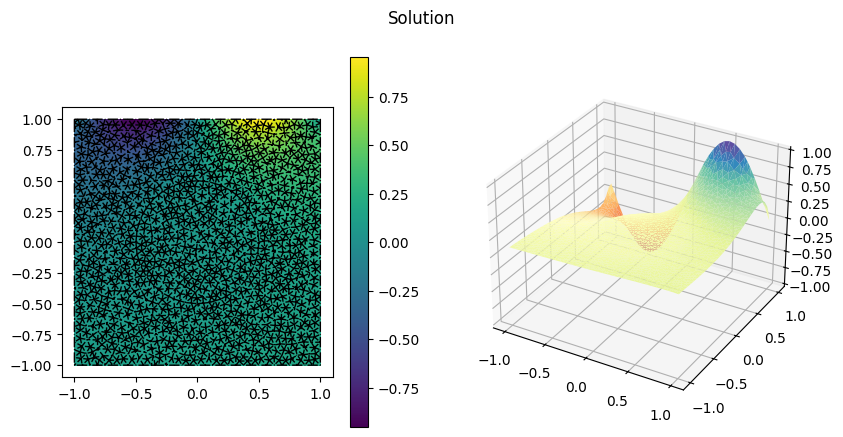

In [30]:
# Project the solution to see it

nn_proj_reduced_solution = basis_functions @ reduced_solution
mu = x_test[0]
thetaA2 = mu[0].item()
thetaf1 = mu[1].item()
mu_3 = mu[2].item()
thetaA1 = 1
Dirichlet_top = gedim.AssembleStrongSolution(Dirichlet_Term, 3, problemData, lib)
 

gedim.PlotSolution(mesh, dofs, strongs, nn_proj_reduced_solution, Dirichlet_top)
# The problem is quite constant to zero and is also tricky for the NN
# Variability can help better to understand in which direction goes

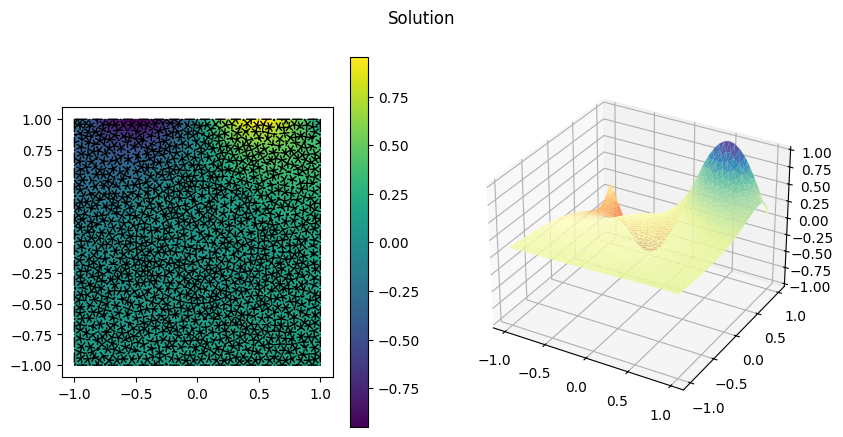

In [31]:
##### full #####

stiffness = thetaA1*stiffness1 + thetaA2*stiffness2
weakTerm_down = thetaf1*weakTerm_down1
f = weakTerm_down - (thetaA1*stiffnessStrong1 + thetaA2*stiffnessStrong2) @ Dirichlet_top
full_solution = gedim.LUSolver(stiffness, f, lib)
  
full_solution = gedim.LUSolver(stiffness, f, lib)
gedim.PlotSolution(mesh, dofs, strongs, full_solution, Dirichlet_top) # Plotting the FOM solution (the ground trouth)

Let us perform an error analysis and comment on the speed up!

In [32]:
### compute error
import time

abs_err = []
rel_err = []
testing_set = np.random.uniform(low=P[:, 0], high=P[:, 1], size=(100, P.shape[0]))
speed_up = []

print("Computing error and speedup analysis") # Compute the erorr

for mu in testing_set:
  
  thetaA2 = mu[0]
  thetaf1 = mu[1]
  mu_3 = mu[2]
  
  #### I DO NOT NEED THE SOLVER #####
    # No need to assemble --> no solve any kind of system, just call the net
  Dirichlet_top = gedim.AssembleStrongSolution(Dirichlet_Term, 3, problemData, lib) ## label 
  
  ##### full #####
  stiffness = thetaA1*stiffness1 + thetaA2*stiffness2
  weakTerm_down = thetaf1*weakTerm_down1
  f = weakTerm_down - (thetaA1*stiffnessStrong1 + thetaA2*stiffnessStrong2) @ Dirichlet_top
  
  
  start_fom = time.time()
  full_solution = gedim.LUSolver(stiffness, f, lib)
  time_fom = time.time() - start_fom
  # gedim.PlotSolution(mesh, dofs, strongs, full_solution, Dirichlet_top)
  
  #### reduced #####
  x_test = [[mu[0], mu[1], mu[2]]]
  x_test = np.float32(x_test)
  x_test = torch.tensor(x_test)

  start_rom = time.time()
  reduced_solution = np.asarray(net(x_test).detach().numpy())[0]
  time_rom = time.time() - start_rom
  
  speed_up.append(time_fom/(time_rom))
  
  proj_reduced_solution = basis_functions@reduced_solution
  # gedim.PlotSolution(mesh, dofs, strongs, proj_reduced_solution, Dirichlet_top)

  ### computing error
  error_function = full_solution - proj_reduced_solution
  error_norm_squared_component = np.transpose(error_function) @ inner_product @ error_function
  absolute_error = np.sqrt(abs(error_norm_squared_component))
  print(absolute_error)
  abs_err.append(absolute_error)
  
  full_solution_norm_squared_component = np.transpose(full_solution) @  inner_product @ full_solution
  relative_error = absolute_error/np.sqrt(abs(full_solution_norm_squared_component))
  rel_err.append(relative_error)
  print(relative_error)
  
# There are a lot of variablity in the errors

Computing error and speedup analysis
0.02821184718236291
0.014908633525250271
0.07616442397872149
0.015541296347706929
0.03766335037575535
0.009276231385921324
0.05719365989801668
0.014810570624140118
0.032620691231664285
0.013750165623966614
0.0405729203923825
0.008127863478883427
0.05900610769209333
0.012249218116076082
0.037401050686081634
0.00839834230956689
0.09512669743667924
0.019592785374797927
0.07050750194533502
0.01470807803004408
0.06127180256855271
0.012129656663648057
0.02045637606995963
0.0043147546530735055
0.03503938564104698
0.009261329038292005
0.027333812545155343
0.017505357024757827
0.03951699594194714
0.016443723627136062
0.08257323132842302
0.01638081395057979
0.06555599461016136
0.013988320972191347
0.07212403030351155
0.02072005363901202
0.03876076559983442
0.008767042409436874
1.617604829332954
0.32895825887977853
0.6837192040850134
0.13847357856053077
0.04227339745004451
0.008397214339237256
0.07107951639756235
0.014676881620522131
0.054006771452411784
0.012

In [33]:
# The error increase, because we are using ML and so loose accuracy --> the better part is that we go faster
print("avarege relative error = ", np.mean(rel_err) )
print("avarege absolute error = ", np.mean(abs_err) )
print("avarege speed_up = ", np.mean(speed_up) ) # BUT we are faster!

# See the graph in notes 3 for more details on the error

avarege relative error =  0.02530663317527609
avarege absolute error =  0.08746066292620291
avarege speed_up =  36.87536589607264
